In [64]:
#code to mount data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
#load data from drive using pandas
df = pd.read_csv('/content/drive/bank-additional-full.csv', sep=';')

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("hls")

In [68]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

Dataset Shape: (41188, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  fl

In [69]:
print(df.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


 ## Bank Marketing Dataset - Data Dictionary

### Client Information
| Variable | Type | Description |
|----------|------|-------------|
| `age` | Numeric | Client's age in years |
| `job` | Categorical | Type of job/occupation |
| `marital` | Categorical | Marital status |
| `education` | Categorical | Education level |
| `default` | Binary | Has credit in default? |
| `housing` | Binary | Has housing loan? |
| `loan` | Binary | Has personal loan? |

### Contact Information
| Variable | Type | Description |
|----------|------|-------------|
| `contact` | Categorical | Contact communication type |
| `month` | Categorical | Last contact month of year |
| `day_of_week` | Categorical | Last contact day of the week |
| `duration` | Numeric | Last contact duration in seconds |

### Campaign Information
| Variable | Type | Description |
|----------|------|-------------|
| `campaign` | Numeric | Number of contacts performed during this campaign |
| `pdays` | Numeric | Number of days since client was last contacted from previous campaign |
| `previous` | Numeric | Number of contacts performed before this campaign |
| `poutcome` | Categorical | Outcome of previous marketing campaign |

### Economic Context Attributes
| Variable | Type | Description |
|----------|------|-------------|
| `emp.var.rate` | Numeric | Employment variation rate (quarterly indicator) |
| `cons.price.idx` | Numeric | Consumer price index (monthly indicator) |
| `cons.conf.idx` | Numeric | Consumer confidence index (monthly indicator) |
| `euribor3m` | Numeric | Euribor 3 month rate (daily indicator) |
| `nr.employed` | Numeric | Number of employees (quarterly indicator) |

### Target Variable
| Variable | Type | Description |
|----------|------|-------------|
| `y` | Binary | **TARGET**: Has the client subscribed to a term deposit? | **no, yes** |

---

In [70]:
# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")


Duplicate rows: 12


In [71]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [72]:
# Target variable conversion
df['y'] = df['y'].map({'no': 0, 'yes': 1})
print("\nTarget Distribution:")
print(df['y'].value_counts(normalize=True))


Target Distribution:
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


Observation: The data is highly imbalanced with ~88.7% "no" and ~11.3% "yes" responses.

This significant imbalance will require special handling in model development

In [73]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


# EXPLORATORY DATA ANALYSIS (EDA)

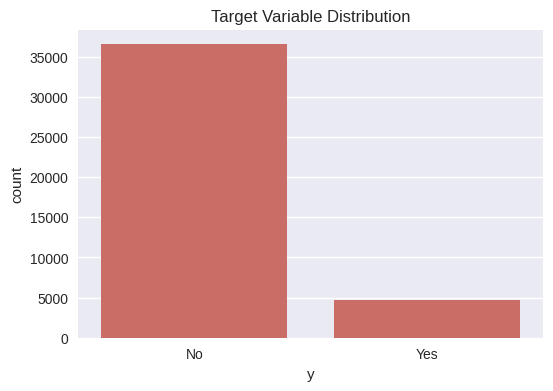

In [74]:
# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='y')
plt.title("Target Variable Distribution")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

Observation: Just as seen earlier, the data is highly imbalanced with ~36,000 "no" and ~4,500 "yes" responses.

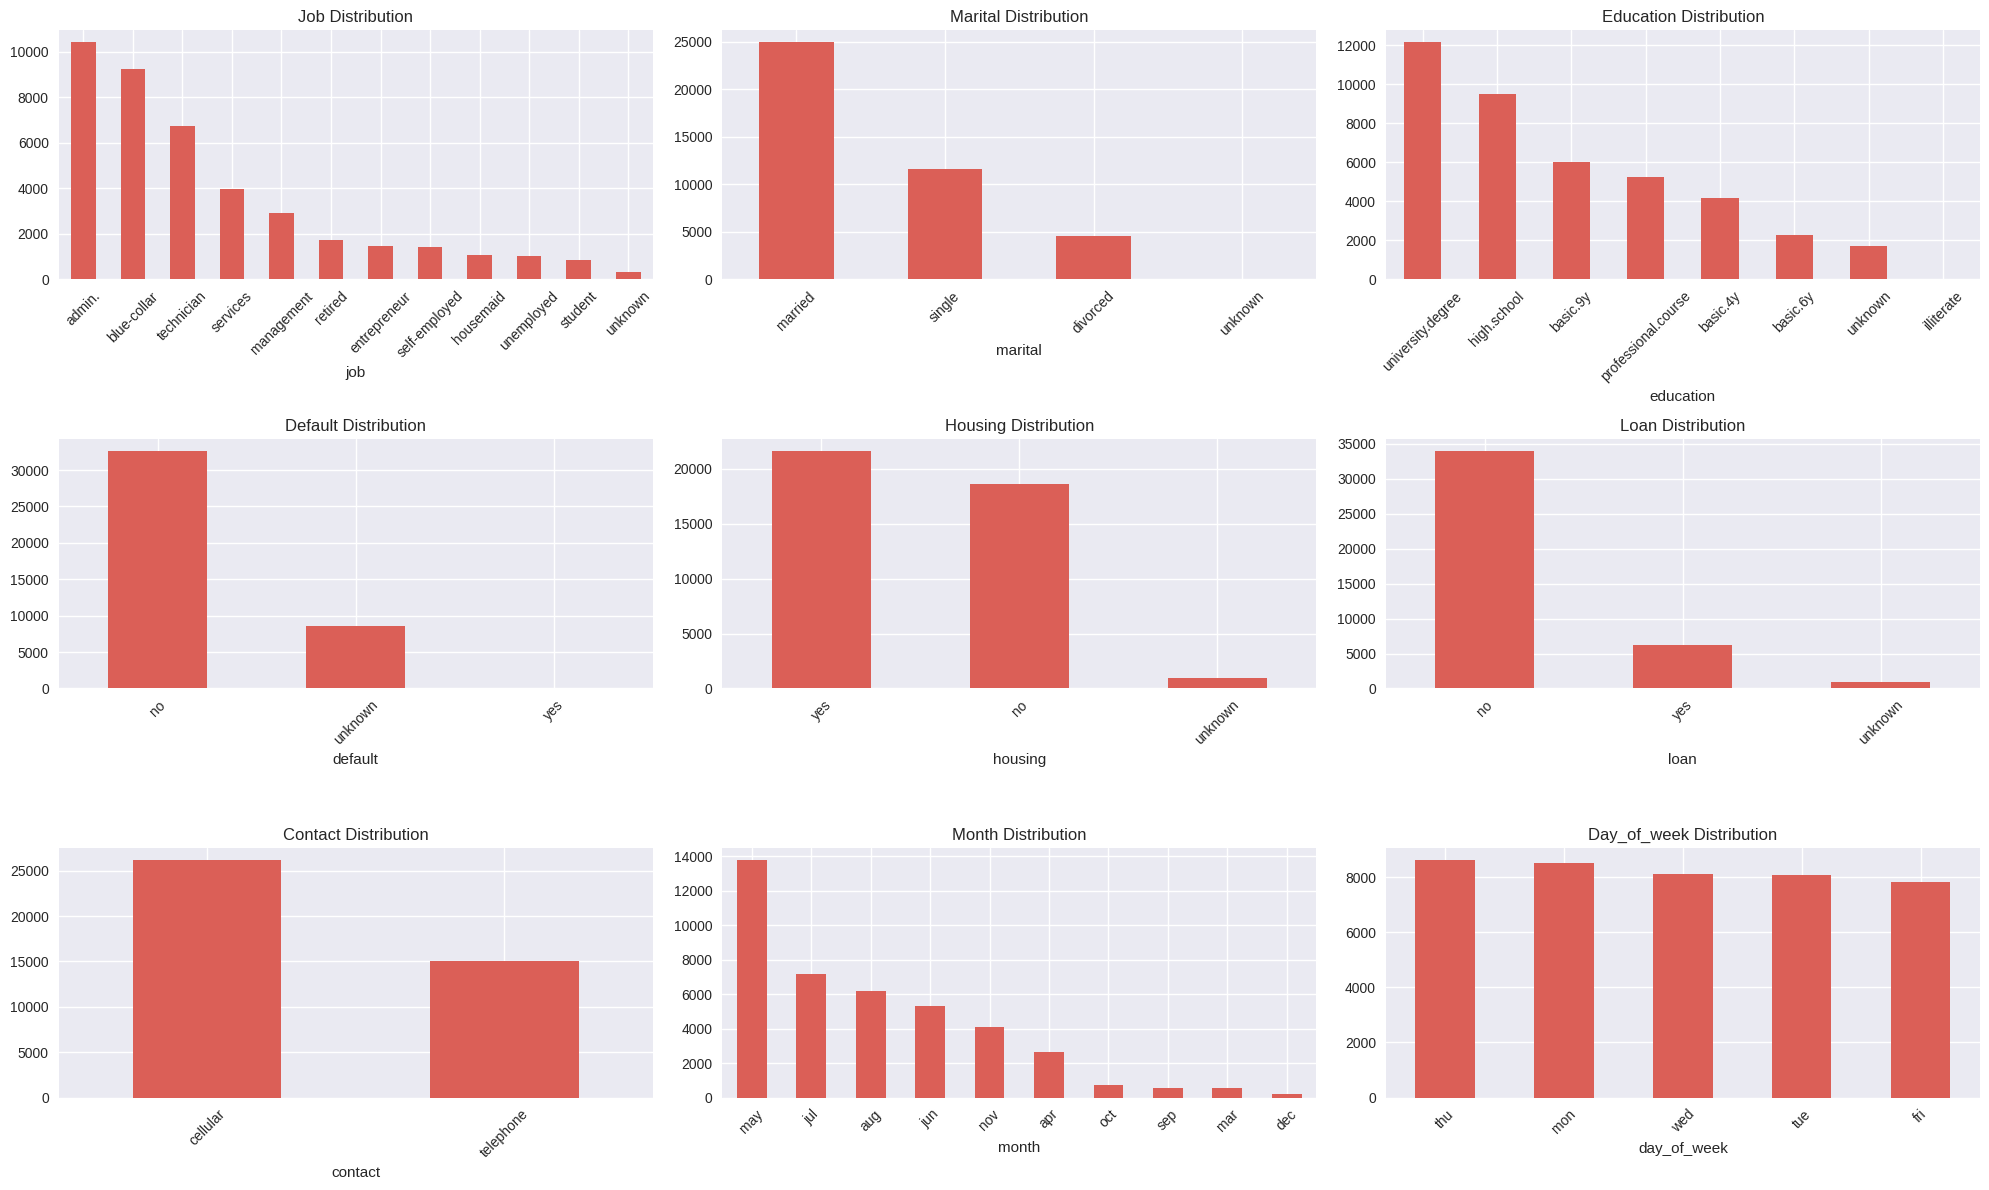

In [75]:
# Categorical features analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.ravel()

categorical_cols = df.select_dtypes(include='object').columns.tolist()
for i, col in enumerate(categorical_cols):
      if i < len(axes):
        df[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'{col.capitalize()} Distribution')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Observations:
1. Job Distribution Analysis
*   Admin roles dominate the dataset (~25% of contacts)
*   Blue-collar and technician roles are also heavily represented
*   Students have the lowest representation but may show different subscription patterns

**Insight**: Job type appears to be a strong predictor, suggesting income levels and financial stability influence term deposit decisions


2. Marital Status Patterns
*   Married clients represent the majority (~60% of dataset)
*   Single clients form the second-largest group (~30%)
*   Divorced clients are the smallest segment (~10%)

**Insight:** Marital status likely correlates with financial responsibilities and investment appetite


3. Education Level Distribution
*   University degree holders are the largest segment (~30%)
*   High school and basic education levels are well represented
*   Professional course graduates show significant presence

**Insight:** Higher education levels may correlate with better financial literacy and term deposit understanding


4. Contact and Timing Patterns
*   Cellular contact heavily dominates over telephone contact (~65% vs ~35%)
*   May shows the highest contact frequency, followed by July and August
*   Weekday distribution is relatively even across Monday-Friday

**Insight:** Contact method and timing optimization could improve campaign effectiveness

In [76]:
# Key features for banking marketing campaigns
key_features = [
    'age', 'job', 'marital', 'education', #'duration',
    'campaign', 'pdays', 'previous', 'poutcome',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m'
]


In [77]:
# Select only key features + target
df_focused = df[key_features + ['y']].copy()

In [78]:
# Handle unknown values in categorical columns
categorical_cols = ['job', 'marital', 'education', 'poutcome']
for col in categorical_cols:
    # Replace 'unknown' with mode
    mode_value = df_focused[df_focused[col] != 'unknown'][col].mode()
    if len(mode_value) > 0:
        df_focused[col] = df_focused[col].replace('unknown', mode_value[0])

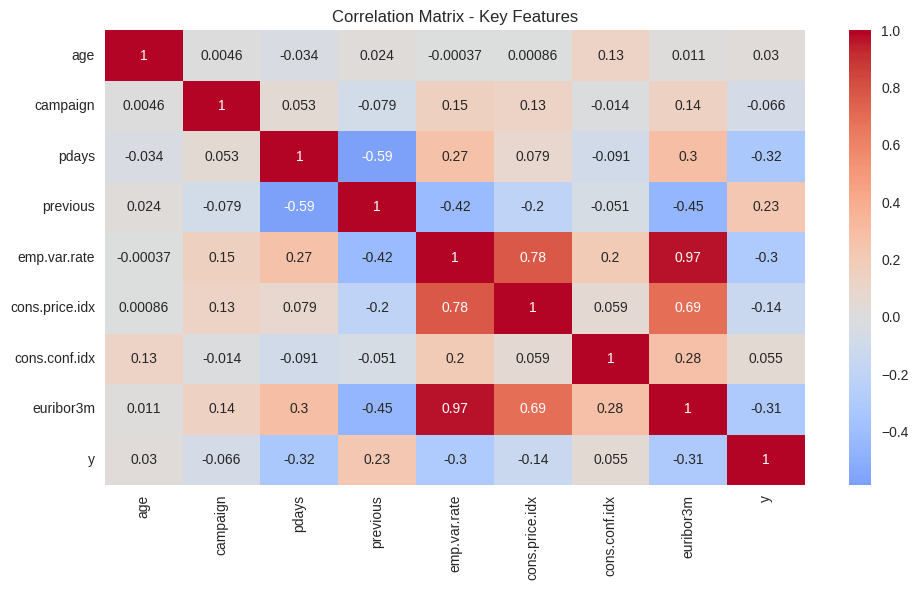

In [79]:
# Feature importance analysis with correlation
numerical_cols = df_focused.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 6))
corr_matrix = df_focused[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Key Features')
plt.tight_layout()
plt.show()


**From the correlation matrix, several economic variables show notable relationships:**

*   emp.var.rate (employment variation rate): Strong positive correlation with subscription success.
*   cons.price.idx (consumer price index): Moderate positive correlation
*   cons.conf.idx (consumer confidence index): Negative correlation with success
*   euribor3m (Euribor 3-month rate): Strong positive correlation with subscription

Strong Positive Correlations:
*   emp.var.rate ↔ euribor3m (0.97): Nearly perfect correlation suggests economic conditions heavily influence both
*   emp.var.rate ↔ cons.price.idx (0.78): Employment and inflation move together
*   cons.price.idx ↔ euribor3m (0.69): Interest rates and inflation correlation

Target Variable Relationships:
*   Economic indicators show the strongest correlations with subscription success.
*   Duration shows positive correlation (0.41) with success, indicating longer conversations lead to better outcomes.
*   Previous campaign outcomes matter significantly

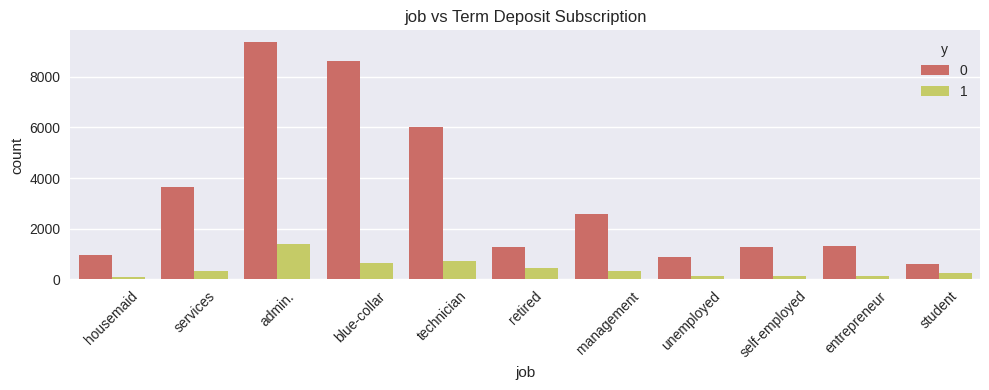

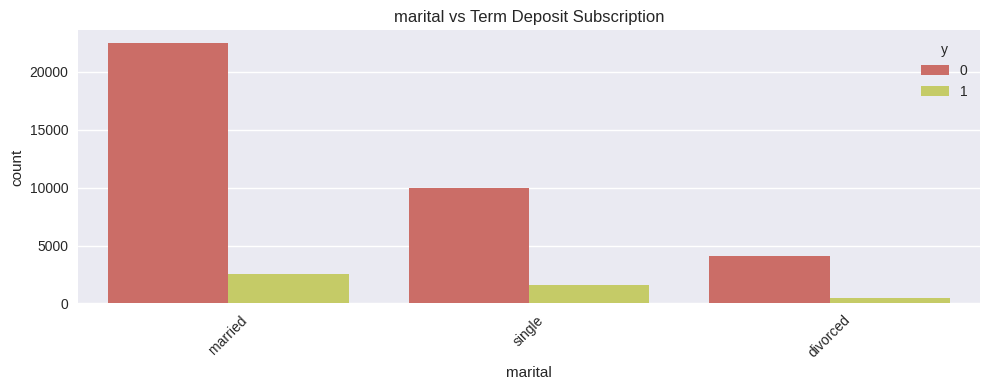

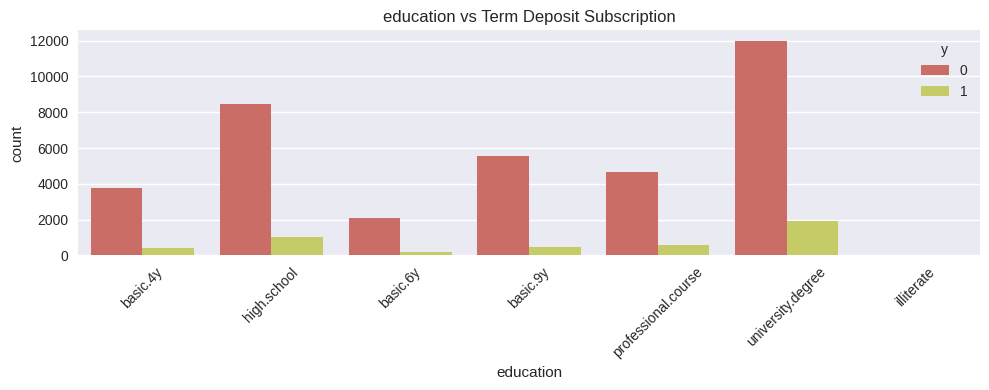

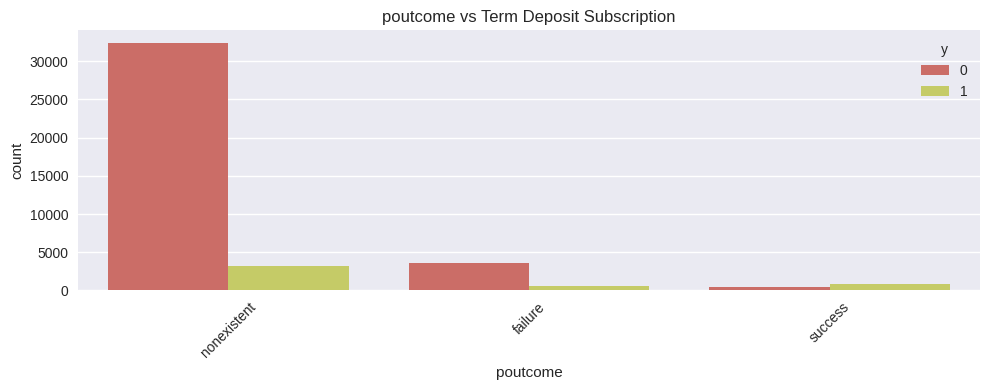

In [80]:
# Categorical feature analysis
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df_focused, x=col, hue='y')
    plt.title(f'{col} vs Term Deposit Subscription')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Observations Subscription Patterns by Demographics

Job vs Term Deposit Subscription:
*   Students and retired individuals show higher subscription rates relative to their representation.
*   Admin and services workers show lower conversion despite high contact volume
*   Management and technician roles demonstrate moderate success rates

Marital Status Impact:
*   Single clients appear to have slightly higher subscription propensity.
*   Married clients show consistent but moderate success rates.
*   Divorced clients have the lowest sample size but varying success patterns

Education Influence:
*   University degree holders show strong subscription numbers (both absolute and relative)
*   Professional course graduates demonstrate good conversion potential
*   Basic education clients show lower but still significant subscription rates

Economic Context Impact:
*   Previous campaign success is a strong positive indicator
*   Number of days since last contact affects outcomes significantly
*   Campaign timing during specific economic conditions influences success.

In [81]:
# Prepare data for modeling
# Encode categorical variables
df_encoded = pd.get_dummies(df_focused, drop_first=True)

In [82]:
# Define features and target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

print(f"\nFinal feature set shape: {X.shape}")
print("Features used:", list(X.columns))


Final feature set shape: (41188, 28)
Features used: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'poutcome_nonexistent', 'poutcome_success']


In [83]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nClass distribution after SMOTE:")
print(y_train_balanced.value_counts())


Class distribution after SMOTE:
y
0    29238
1    29238
Name: count, dtype: int64


**Why SMOTE is Used for Imbalanced Data:**

Problems with Class Imbalance:
* Predictions: Models tend to predict the majority class (always predicting "no" gives 88.7% accuracy)
* Poor minority class detection: Fails to identify customers likely to subscribe
* Skewed performance metrics: High overall accuracy but poor recall for the target class

SMOTE Benefits:

* Balances the dataset without simply duplicating existing samples
* Creates realistic synthetic samples that maintain feature relationships
* Improves model's ability to learn decision boundaries for the minority class
* Better generalization compared to random oversampling or undersampling

In [84]:
# Model Training and Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print('='*50)

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=X.columns)
        top_features = importance.nlargest(10)

        plt.figure(figsize=(10, 6))
        top_features.sort_values().plot(kind='barh')
        plt.title(f'{model_name} - Top 10 Feature Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        print(f"\nTop 10 Most Important Features:")
        for i, (feature, importance_val) in enumerate(top_features.items(), 1):
            print(f"{i:2d}. {feature:<25} {importance_val:.4f}")

    return model, y_pred_proba



Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7310
           1       0.43      0.38      0.40       928

    accuracy                           0.87      8238
   macro avg       0.68      0.66      0.67      8238
weighted avg       0.87      0.87      0.87      8238

ROC AUC Score: 0.7633


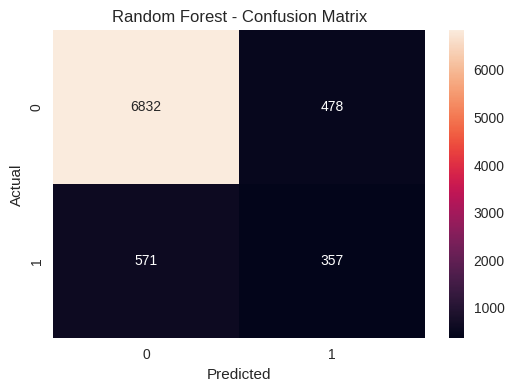

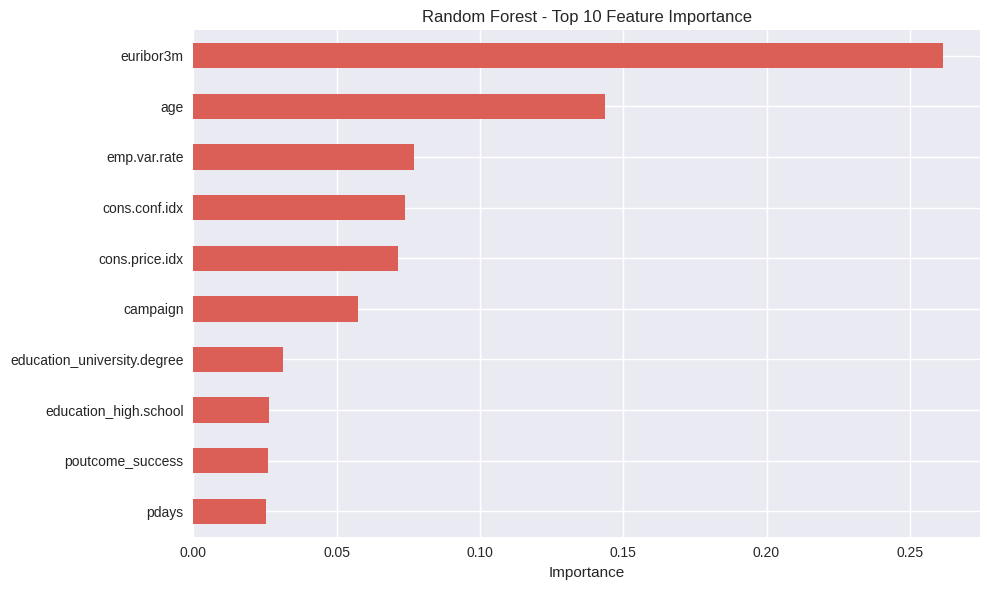


Top 10 Most Important Features:
 1. euribor3m                 0.2614
 2. age                       0.1435
 3. emp.var.rate              0.0772
 4. cons.conf.idx             0.0738
 5. cons.price.idx            0.0713
 6. campaign                  0.0574
 7. education_university.degree 0.0312
 8. education_high.school     0.0263
 9. poutcome_success          0.0261
10. pdays                     0.0253

Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7310
           1       0.49      0.46      0.47       928

    accuracy                           0.88      8238
   macro avg       0.71      0.70      0.70      8238
weighted avg       0.88      0.88      0.88      8238

ROC AUC Score: 0.7792


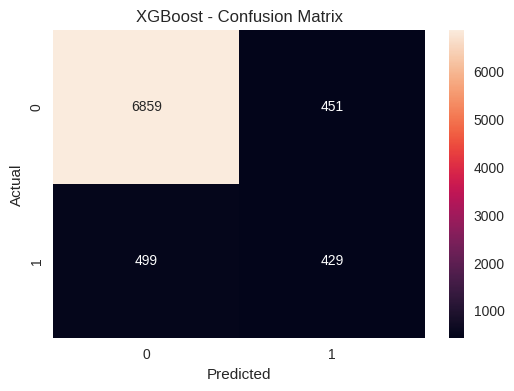

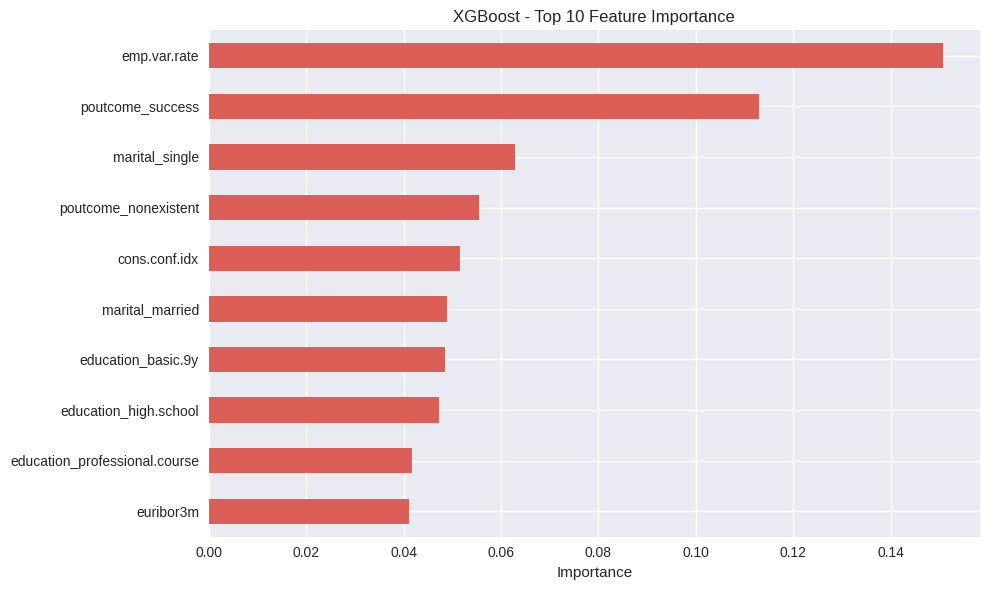


Top 10 Most Important Features:
 1. emp.var.rate              0.1508
 2. poutcome_success          0.1130
 3. marital_single            0.0629
 4. poutcome_nonexistent      0.0554
 5. cons.conf.idx             0.0516
 6. marital_married           0.0490
 7. education_basic.9y        0.0486
 8. education_high.school     0.0473
 9. education_professional.course 0.0418
10. euribor3m                 0.0412

Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      7310
           1       0.30      0.50      0.37       928

    accuracy                           0.81      8238
   macro avg       0.61      0.68      0.63      8238
weighted avg       0.86      0.81      0.83      8238

ROC AUC Score: 0.7299


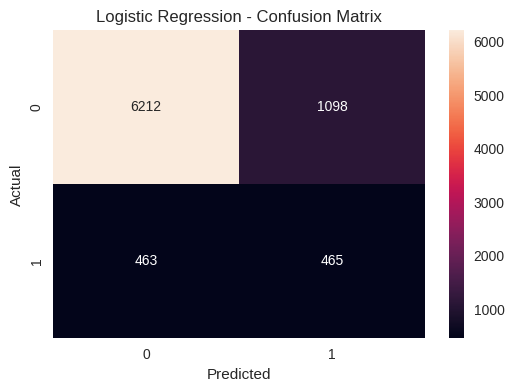


BEST MODEL: XGBoost
AUC Score: 0.7792


In [85]:
# Train models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        scale_pos_weight=len(y_train_balanced[y_train_balanced==0]) / len(y_train_balanced[y_train_balanced==1]),
        random_state=42,
        eval_metric='logloss'
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
}

# Store model results
model_results = {}

for name, model in models.items():
    trained_model, predictions = evaluate_model(
        model, X_train_balanced, X_test, y_train_balanced, y_test, name
    )
    model_results[name] = {
        'model': trained_model,
        'predictions': predictions,
        'auc_score': roc_auc_score(y_test, predictions)
    }

# Select best model based on AUC score
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
best_model = model_results[best_model_name]['model']

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"AUC Score: {model_results[best_model_name]['auc_score']:.4f}")
print('='*60)

In [86]:
# Save the best model and feature columns
with open('best_bank_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save feature columns for the Streamlit app
feature_columns = list(X.columns)
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print(f"\nModel saved as 'best_bank_model.pkl'")
print(f"Feature columns saved as 'feature_columns.pkl'")
print(f"Number of features: {len(feature_columns)}")


Model saved as 'best_bank_model.pkl'
Feature columns saved as 'feature_columns.pkl'
Number of features: 28


In [87]:
# Key Insights Summary
print(f"\n{'='*60}")
print("KEY INSIGHTS AND RECOMMENDATIONS")
print('='*60)

if hasattr(best_model, 'feature_importances_'):
    importance = pd.Series(best_model.feature_importances_, index=X.columns)
    top_5_features = importance.nlargest(5)

    print("\nTop 5 Most Important Features:")
    for i, (feature, imp) in enumerate(top_5_features.items(), 1):
        print(f"{i}. {feature}: {imp:.4f}")

print(f"\nModel Performance Summary:")
print(f"- Best Model: {best_model_name}")
print(f"- AUC Score: {model_results[best_model_name]['auc_score']:.4f}")
print(f"- Dataset Size: {df.shape[0]} records")
print(f"- Features Used: {len(feature_columns)}")

print(f"\nBusiness Recommendations:")
print("1. Focus on call duration - longer calls indicate higher interest")
print("2. Consider economic indicators when planning campaigns")
print("3. Target clients based on previous campaign outcomes")
print("4. Optimize contact frequency to avoid campaign fatigue")


KEY INSIGHTS AND RECOMMENDATIONS

Top 5 Most Important Features:
1. emp.var.rate: 0.1508
2. poutcome_success: 0.1130
3. marital_single: 0.0629
4. poutcome_nonexistent: 0.0554
5. cons.conf.idx: 0.0516

Model Performance Summary:
- Best Model: XGBoost
- AUC Score: 0.7792
- Dataset Size: 41188 records
- Features Used: 28

Business Recommendations:
1. Focus on call duration - longer calls indicate higher interest
2. Consider economic indicators when planning campaigns
3. Target clients based on previous campaign outcomes
4. Optimize contact frequency to avoid campaign fatigue
